In [8]:
import numpy as np
import pandas as pd
import os
import xarray as xr


import rockhound as rh
from rockhound.slab2 import ZONES
import pygmt


import matplotlib.pyplot as plt


#for some reason we get repetitive deprecation warnings, so this mutes them
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 

In [6]:
def write_xyz_file(output_filename, output_data):
    #print output_filename
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')
    output_file.close()

In [3]:
####
#all sections
# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))
#
#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])
#
grid = global_sub_zones.depth
grid_uncertainty = global_sub_zones.depth_uncertainty

#close more datasets
for zone in subduction_zones:
    del zone
del global_sub_zones

In [7]:
lons = grid.longitude.values
lats = grid.latitude.values
lons_mesh, lats_mesh = np.meshgrid(lons, lats)
data = {'lon': np.ravel(lons_mesh),
        'lat': np.ravel(lats_mesh),
        'depth': np.ravel(grid.data)}
df = pd.DataFrame(data)
df_new = pygmt.blockmedian(df, spacing='0.05', region='g')
del df
del data

In [9]:

export_data = []

for i,j,k in zip(df_new['lon'].values,
                 df_new['lat'].values,
                 df_new['depth'].values):
        export_data.append((i,j,np.float(k)))  

infile = 'tmp_data2'        
output_grd = 'depth_grid.grd'
write_xyz_file(infile, export_data)


In [10]:
infile = 'tmp_data2'        
output_grd = 'depth_grid.grd'
resolution = '0.05'
region='0./360./-90./90.'
search = '5d'
os.system('gmt sphinterpolate %s -G%s -I%s -R%s -V' % (infile, output_grd, resolution, region))
#os.system('gmt surface %s -G%s -I%s -R%s -M%s -V' % (infile, output_grd, resolution, region, search))

0

In [11]:
new_dataset = xr.load_dataset('./depth_grid.grd')

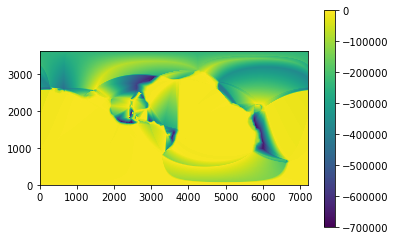

In [12]:
plt.imshow(new_dataset['z'],origin='lower')
plt.colorbar()

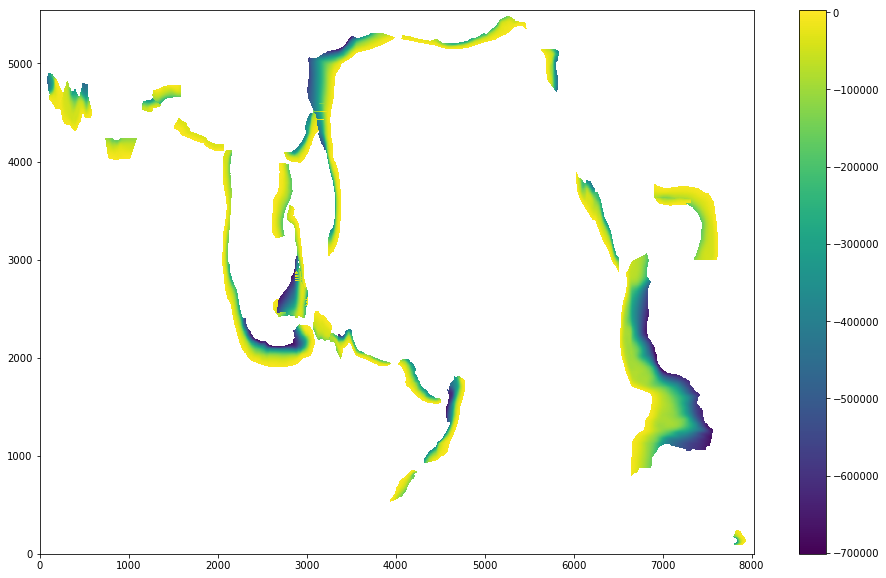

In [13]:
#test plot, not perfect but alright?
plt.figure(figsize=(16,10))
plt.pcolormesh(grid.values)
plt.colorbar()